In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import ndimage
import torch
import torch.optim as optim
from torchvision import transforms, models
import torch.nn as nn
import pdb

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
#vgg = models.resnet34(pretrained=True).cuda()
vgg = models.vgg19(pretrained=True).features.cuda()

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
def img_to_tensor(image):
    in_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
    return in_transform(image)

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize((size,size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image.cuda()

In [5]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [77]:
def show_all(images):
    img_n = len(images)
    rows = int(np.sqrt(img_n))
    cols = (img_n+rows-1) // rows
    _, axs = plt.subplots(rows, cols, figsize=(8*rows,8*cols))
    if len(images) > 1: axs = axs.flatten()
    else: axs = [axs]
    for img, ax in zip(images, axs):
        ax.imshow(im_convert(img.squeeze()))
        ax.axis('off')

In [7]:
def get_random_img(size):
    opt_img = np.random.uniform(0, 1, size=(size,size,3)).astype(np.float32)
    #opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])  
    opt_pil = Image.fromarray(np.uint8(opt_img*255))
    opt_tensor = img_to_tensor(opt_pil).cuda()
    opt_tensor = opt_tensor[None].cuda()
    return opt_tensor

In [8]:
part_vgg = nn.Sequential(*list(vgg.children())[:24])


In [41]:
def content_loss(img, tar):
    return torch.mean((img - tar)**2)


In [119]:
def gram_matrix(tensor):
   
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor.clone(), tensor.clone().t())
    
    return gram / (d*w)

In [120]:
def style_loss(img, tar):
    m_img = gram_matrix(img)
    m_tar = gram_matrix(tar)
    return torch.mean((m_img - m_tar) ** 2)

In [ ]:
input_img.shape, content.shape

In [ ]:
part_vgg(input_img).shape

In [ ]:
loss_fun(part_vgg(input_img), part_vgg(content))

In [ ]:
part_vgg(content)[0,0,:,:]

In [ ]:
def trainLBFGS(opt_img, content_img, until=0.01):
    def one_step():
        output = part_vgg(opt_img)
        loss = loss_fun(output, target)
        optimizer.zero_grad()
        loss.backward()
        return loss
    target = part_vgg(content_img)
    opt_img.requires_grad=True
    optimizer = optim.LBFGS([opt_img])
    lss = float("inf")
    epoch = 0
    while lss > until:
        lss = optimizer.step(one_step)
        epoch +=1
        if epoch % 10 == 0: print(lss)

In [ ]:
def trainAdam(opt_img, content_img, until=0.01, lr=0.01):
    optimizer = optim.Adam([opt_img], lr=0.01)
    target = part_vgg(content_img) 
    opt_img.requires_grad=True
    lss = float("inf")
    epoch = 0
    while lss > until:
        output = part_vgg(opt_img)
        lss = style_loss(output, target)
        optimizer.zero_grad()
        lss.backward()
        optimizer.step()
        epoch += 1
        if epoch % 500 == 0: print(lss)

In [17]:
l_idx =1 
l_d = 1
layer_id2idx ={}
for idx, layer in enumerate(vgg.children()):
    layer_id = f'{l_d}_{l_idx}'
    layer_id2idx[layer_id] = idx
    print(layer_id + ':', layer)
    if isinstance(layer, nn.MaxPool2d):
        l_d +=1
        l_idx = 1
    else:
        l_idx +=1

1_1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_2: ReLU(inplace)
1_3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_4: ReLU(inplace)
1_5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2_1: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_2: ReLU(inplace)
2_3: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_4: ReLU(inplace)
2_5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3_1: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_2: ReLU(inplace)
3_3: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_4: ReLU(inplace)
3_5: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_6: ReLU(inplace)
3_7: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_8: ReLU(inplace)
3_9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
4_1: Conv2d(256, 512, kernel_s

In [34]:
def all_keys(dicts):
    return set([x for d in dicts for x in d])

{0, 2, 3, 4}

In [134]:
def trainOnLayers(opt_imgs, content_img, style_img,  content_layers, style_layers, epochs=1500, lr=0.1):
    assert len(opt_imgs) == len(style_layers) and len(style_layers) == len(content_layers)
    optims = []
    for i in range(len(opt_imgs)):
        optims.append(optim.Adam([opt_imgs[i]], lr=lr))
        opt_imgs[i].requires_grad = True
    content_target = content_img
    style_target = style_img
    content_targets ={}
    style_targets ={}
    used_content = all_keys(content_layers)
    used_style = all_keys(style_layers)
    for idx, layer in enumerate(vgg.children()):
        content_target = layer(content_target)
        style_target = layer(style_target)
        if idx in used_style:
            style_targets[idx] = (style_target.clone())
        if idx in used_content:
            content_targets[idx] = (content_target.clone())
    for epoch in range(epochs):
        losses = []
        last_layer = max(used_content.union(used_style))
        for img_idx in range(len(opt_imgs)):
            style_lss = torch.tensor(0.0).cuda()
            content_lss = torch.tensor(0.0).cuda()
            x = opt_imgs[img_idx]
            for idx, layer in enumerate(vgg.children()):
                x =  layer(x)
                if idx in style_layers[img_idx]:
                    style_lss = style_lss + style_loss(x, style_targets[idx])* style_layers[img_idx][idx]
                if idx in content_layers[img_idx]:
                    content_lss = content_lss +  content_loss(x, content_targets[idx]) * content_layers[img_idx][idx]
            lss = style_lss + content_lss
            optims[img_idx].zero_grad()
            lss.backward()
            optims[img_idx].step()
            losses.append((content_lss.item(), style_lss.item()))
        if epoch % 100 == 99: print(losses)
    return losses

In [96]:
def tensorize(d):
    return {layer_id2idx[a]:torch.tensor(b) for a,b in d.items()}

In [130]:
style_weights = [tensorize({'1_1': 1.}),
                 tensorize({'1_4': 1.}),
                 tensorize({'2_1': 1.}),
                 tensorize({'2_4': 1.}),
                 tensorize({'3_1': 1.})]
content_weights = [tensorize({'4_2': .1})]*5
size = 256
imgs = [get_random_img(size) for i in range(len(style_weights))]
content = load_image('images/slawek.jpg', max_size=size)
style = load_image('images/mona.jpg', max_size=size)

trainOnLayers(imgs, content, style,content_weights,style_weights, 5000,lr=0.01)
show_all(imgs)

KeyboardInterrupt: 

In [ ]:
%%time
style_weights = [tensorize({'1_1': 1.}),
                 tensorize({'1_4': 1.}),
                 tensorize({'2_1': 1.}),
                 tensorize({'2_4': 1.}),
                 tensorize({'3_1': 1.}),
                 tensorize({'3_8': 1.})]
#content_weights = [tensorize({'4_2': .1})]*6
content_weights = [{}]*6
size = 32
imgs = [get_random_img(size) for i in range(len(style_weights))]
TARGET_SIZE = 256
while size <= TARGET_SIZE:
    content = load_image('images/slawek.jpg', max_size=size)
    style = load_image('images/mona.jpg', max_size=size)
    trainOnLayers(imgs, content, style,content_weights,style_weights, 1000,lr=0.01)
    show_all(imgs)
    if size < TARGET_SIZE:
        imgs = [nn.Upsample(scale_factor=2, mode='bilinear')(img).detach_() for img in imgs]
    size *= 2

[(0.0, 0.01937137171626091), (0.0, 0.11505429446697235), (0.0, 5.017893314361572), (0.0, 0.12005702406167984), (0.0, 1.8907475471496582), (0.0, 0.09119449555873871)]
[(0.0, 0.010028215125203133), (0.0, 0.04848410189151764), (0.0, 1.5349295139312744), (0.0, 0.06118190288543701), (0.0, 1.0439175367355347), (0.0, 0.06295610964298248)]
[(0.0, 0.006239250767976046), (0.0, 0.0317714586853981), (0.0, 0.8279601335525513), (0.0, 0.03773873299360275), (0.0, 0.6515889763832092), (0.0, 0.04562833905220032)]
[(0.0, 0.004005551803857088), (0.0, 0.022886211052536964), (0.0, 0.5709140300750732), (0.0, 0.02587875723838806), (0.0, 0.44713181257247925), (0.0, 0.03339298069477081)]
[(0.0, 0.0025742051657289267), (0.0, 0.017364876344799995), (0.0, 0.4401599168777466), (0.0, 0.019880259409546852), (0.0, 0.3259158134460449), (0.0, 0.026121512055397034)]
[(0.0, 0.0016543781384825706), (0.0, 0.01374950259923935), (0.0, 0.35938239097595215), (0.0, 0.016296256333589554), (0.0, 0.2553161382675171), (0.0, 0.022248

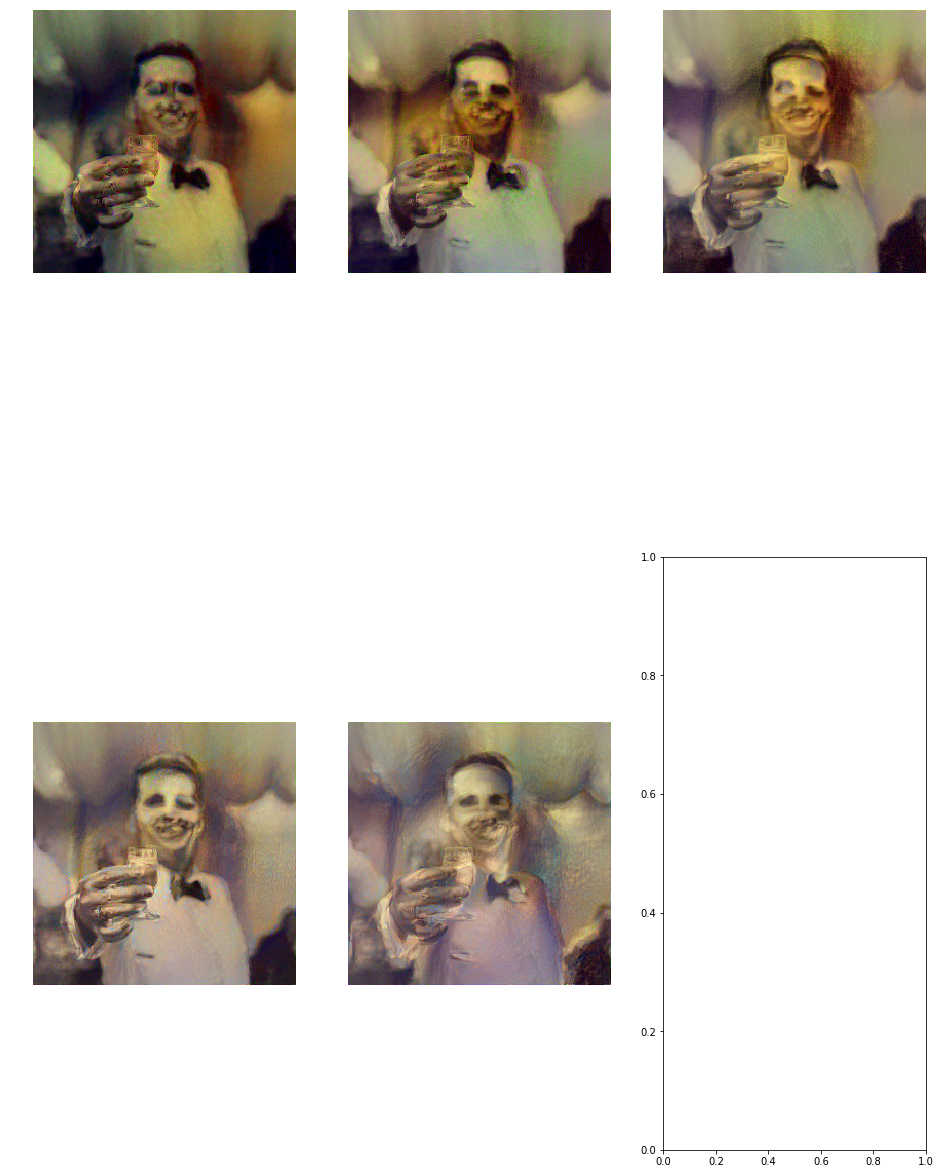

In [132]:
show_all(imgs)

In [127]:
trainOnLayers(imgs, content, style,content_weights,style_weights, 2500,lr=0.01)

[(0.19759878516197205, 0.08201740682125092)]
[(0.19537752866744995, 0.08143363147974014)]
[(0.19439619779586792, 0.08125700056552887)]
[(0.19374597072601318, 0.08104167878627777)]
[(0.19310173392295837, 0.0809420794248581)]
[(0.19275520741939545, 0.08072609454393387)]
[(0.19249112904071808, 0.08048958331346512)]
[(0.1911884993314743, 0.08093461394309998)]
[(0.1907843053340912, 0.0806681215763092)]
[(0.19011257588863373, 0.08075197041034698)]
[(0.1897876113653183, 0.08033730834722519)]
[(0.188375785946846, 0.0813058614730835)]
[(0.18867896497249603, 0.08017253875732422)]
[(0.18769828975200653, 0.08066774904727936)]
[(0.18745535612106323, 0.08043953776359558)]
[(0.18716637790203094, 0.07994828373193741)]
[(0.18656283617019653, 0.08014652878046036)]
[(0.18576635420322418, 0.08023986220359802)]
[(0.18537797033786774, 0.08020111173391342)]
[(0.18504370748996735, 0.0798788070678711)]
[(0.18440131843090057, 0.08068671077489853)]
[(0.18475501239299774, 0.07993055135011673)]
[(0.184244140982627

[(0.18366830050945282, 0.07954274863004684)]

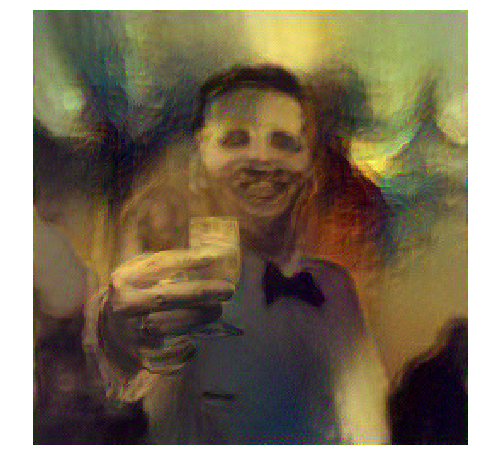

In [128]:
show_all(imgs)

training  32
[0.02902097813785076, 0.09628795087337494, 0.03022468462586403, 0.02028672769665718]
[0.00802415981888771, 0.04328126460313797, 0.01151946745812893, 0.019799131900072098]
[0.0027884775772690773, 0.03001856803894043, 0.005744498688727617, 0.01588127762079239]
[0.0014026183634996414, 0.02401343733072281, 0.003936127293854952, 0.016129080206155777]
[0.0008544576703570783, 0.020120546221733093, 0.003136872546747327, 0.013293914496898651]
training  64
[0.001458840211853385, 0.08892685920000076, 0.028787031769752502, 0.014856788329780102]
[0.0002997256815433502, 0.03917146101593971, 0.011406676843762398, 0.00965903326869011]
[0.00011499508400447667, 0.02545863203704357, 0.0060909707099199295, 0.007197787053883076]
[6.046620546840131e-05, 0.01923159882426262, 0.0040713949128985405, 0.005457750055938959]
[3.681069574668072e-05, 0.015389366075396538, 0.0031629547011107206, 0.004440824966877699]
training  128
[0.00028946573729626834, 0.06894893944263458, 0.03661176562309265, 0.01263

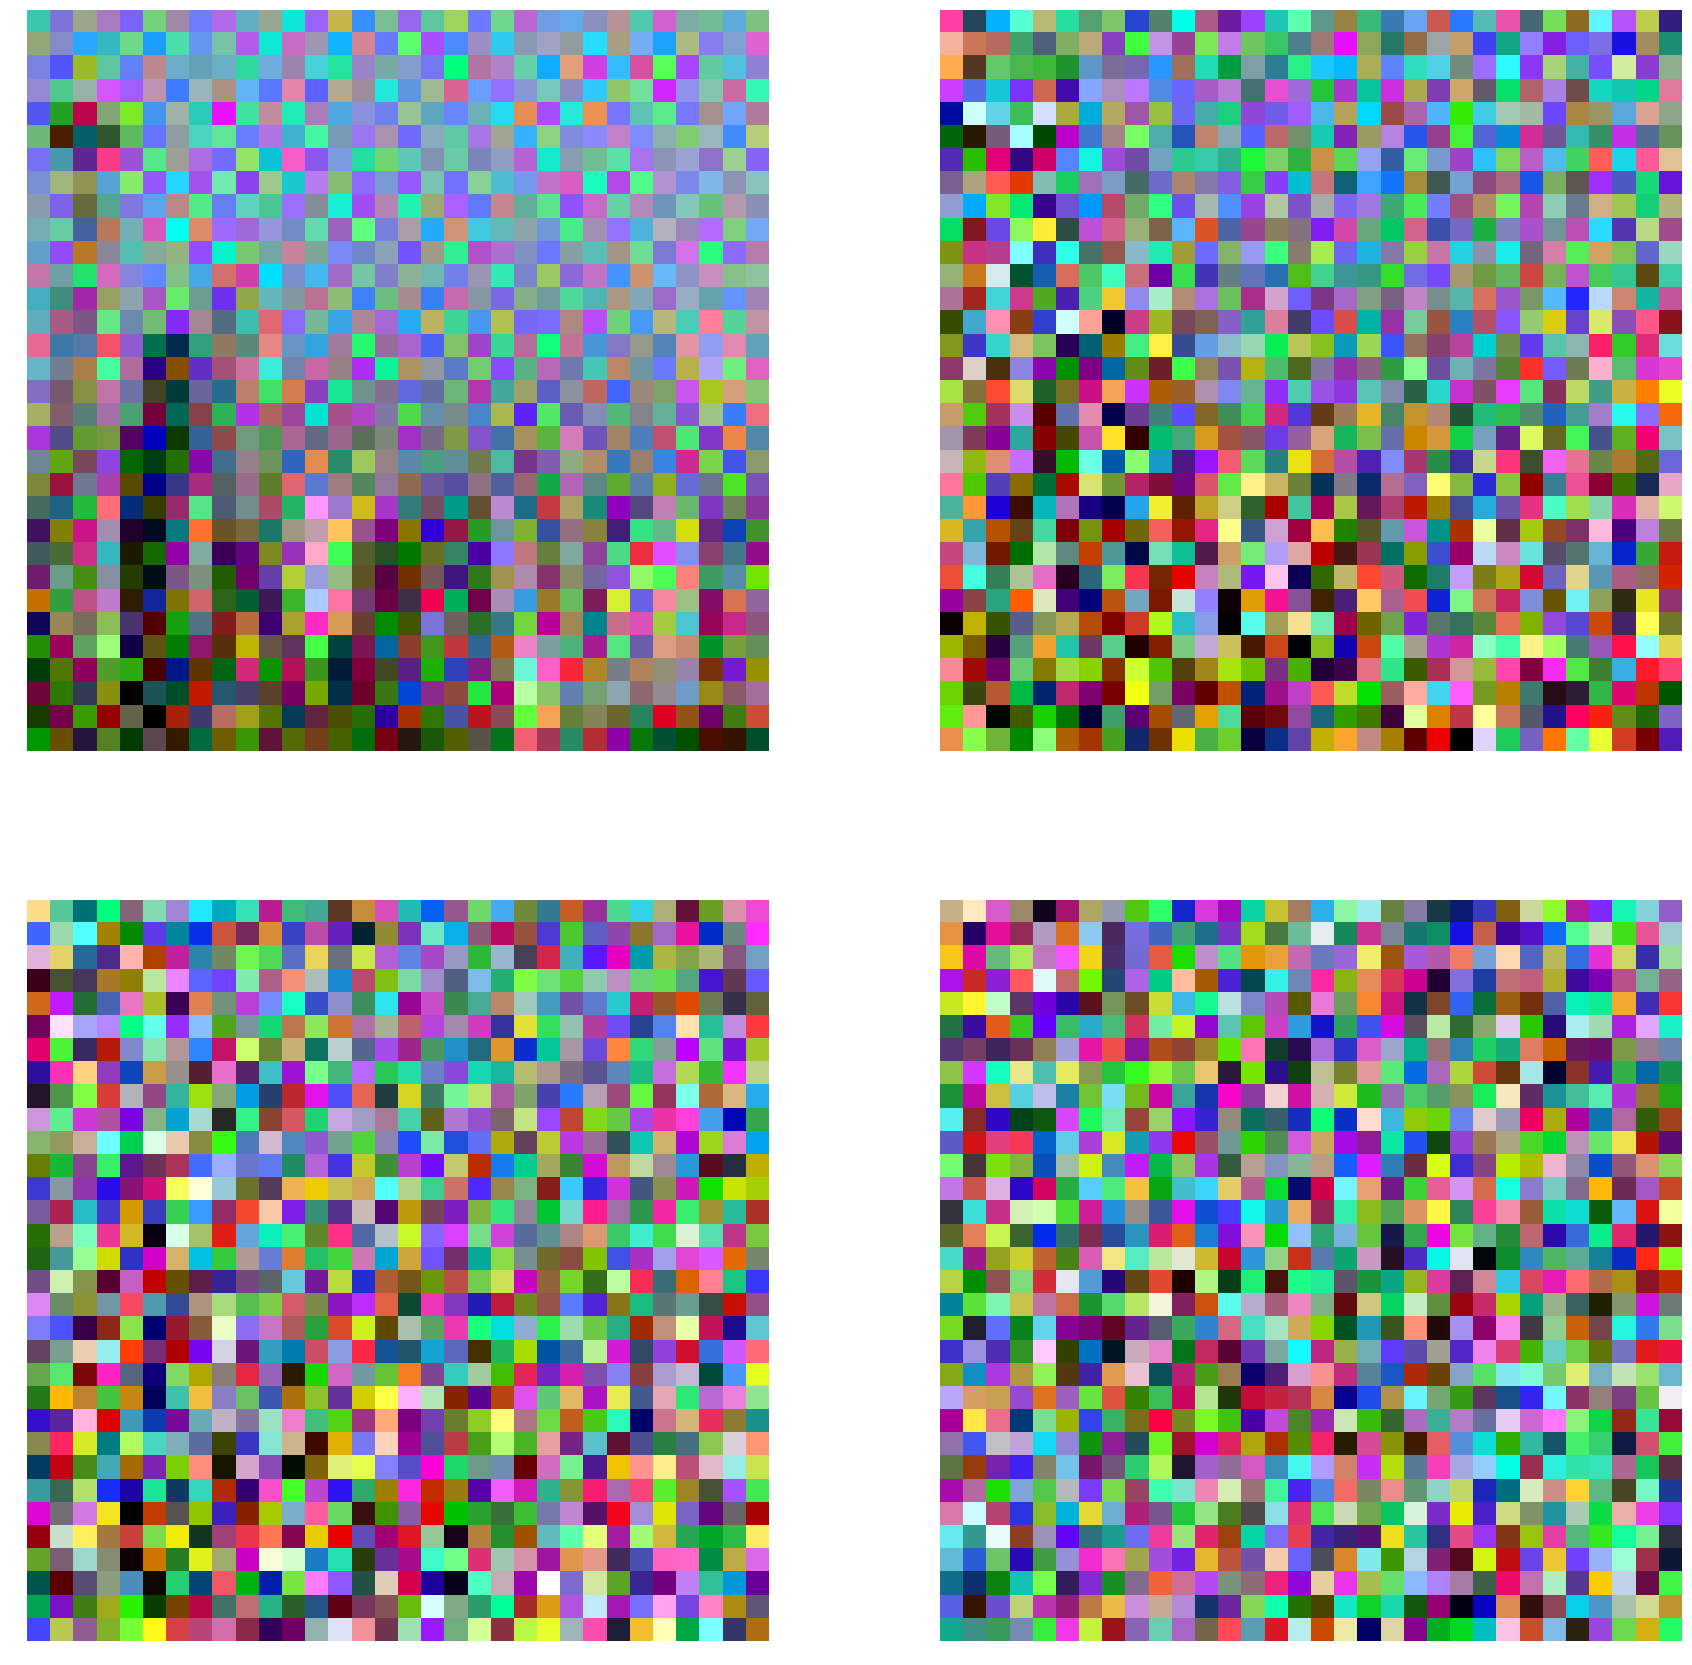

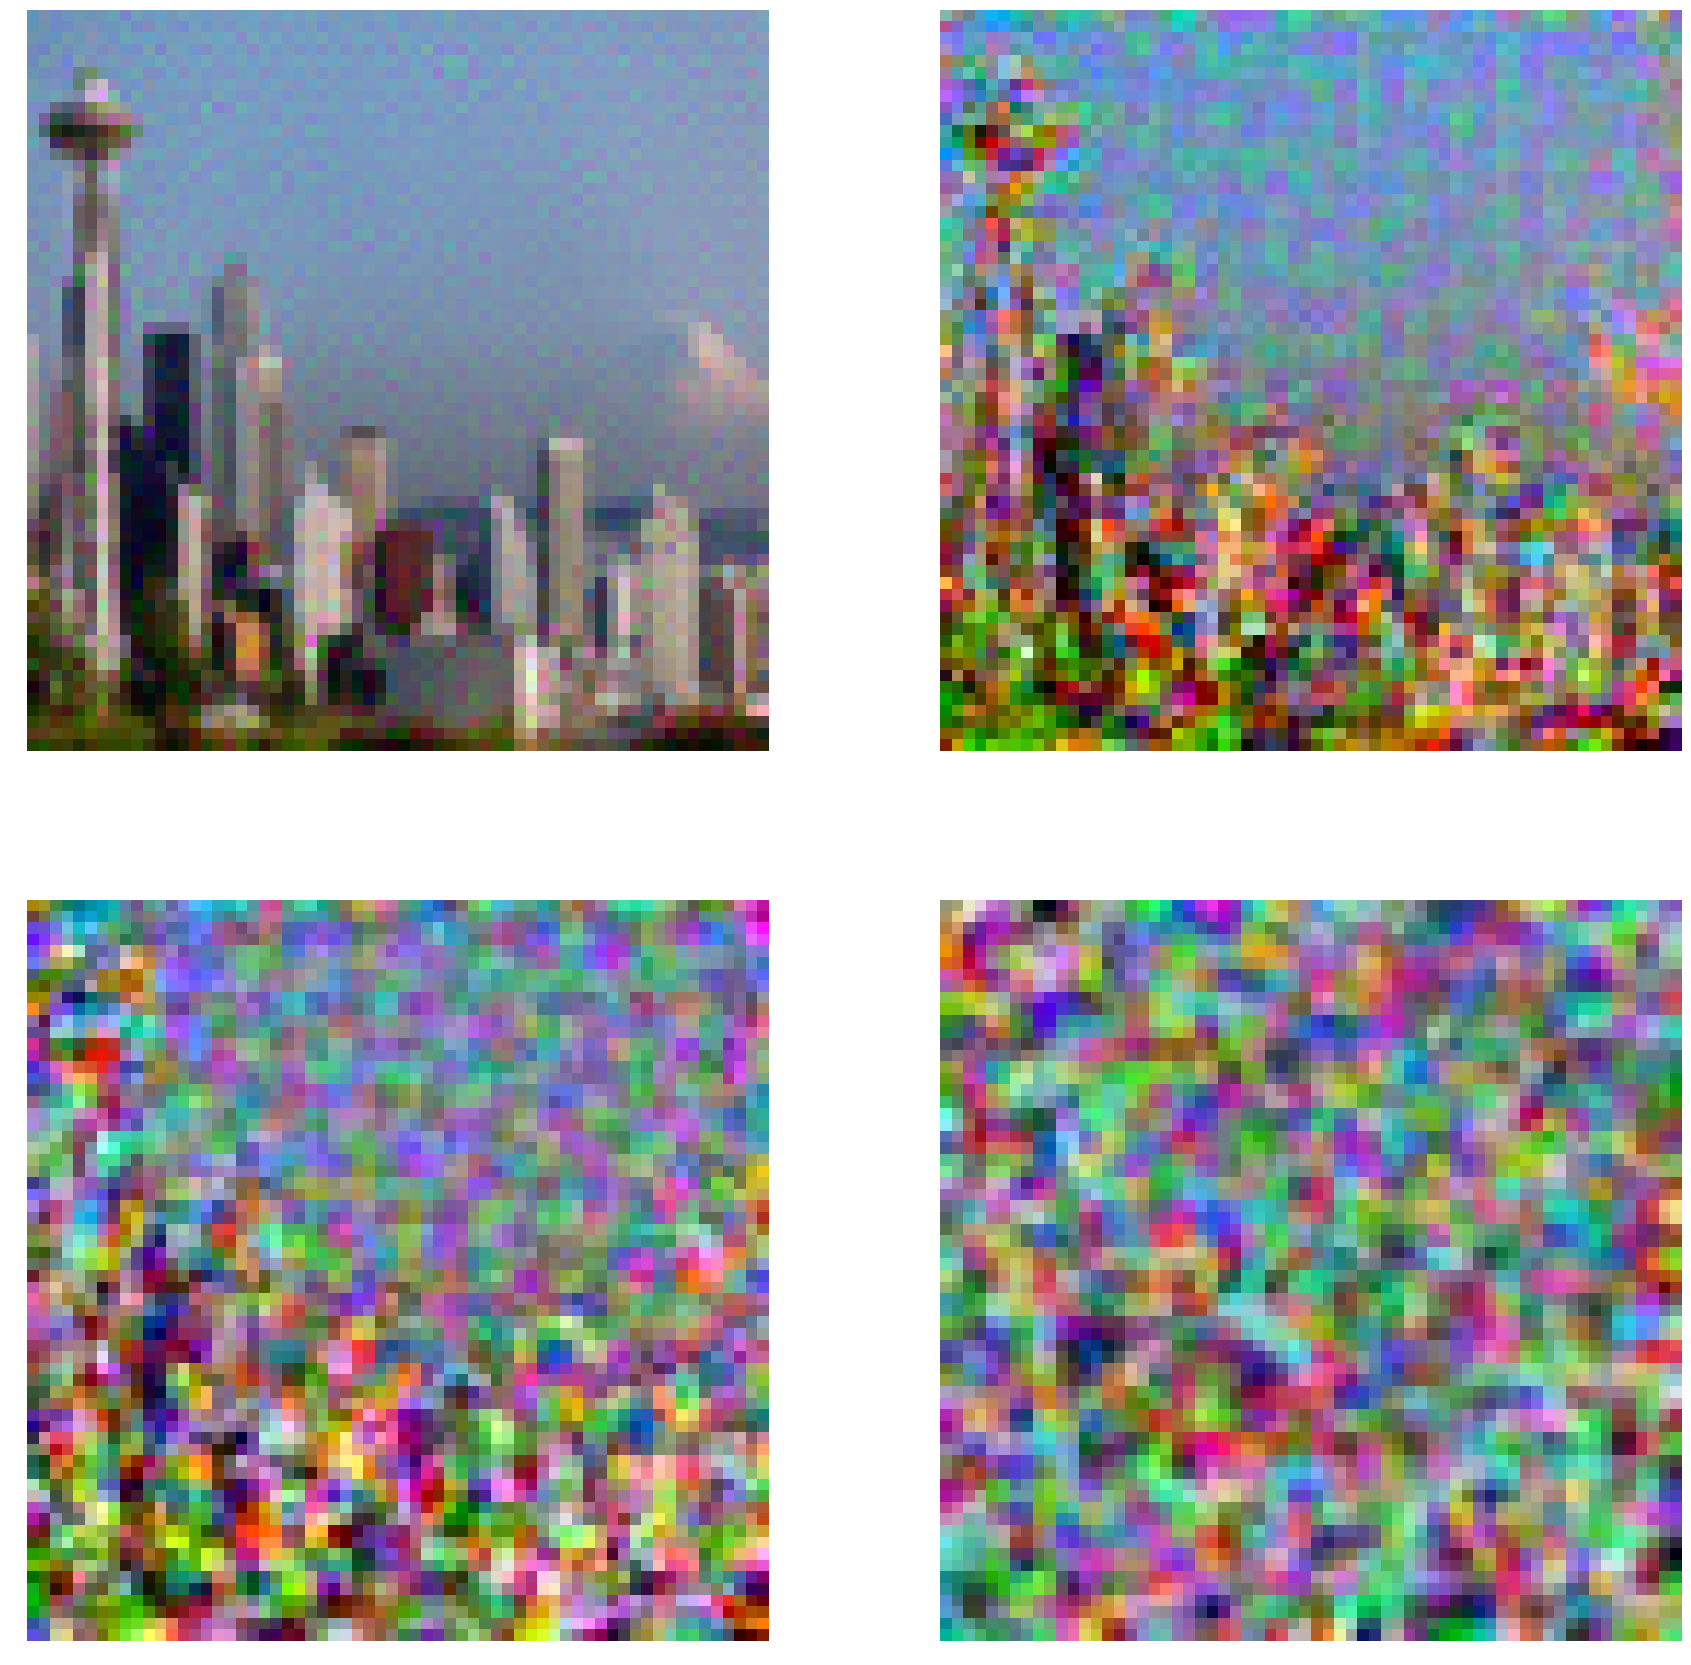

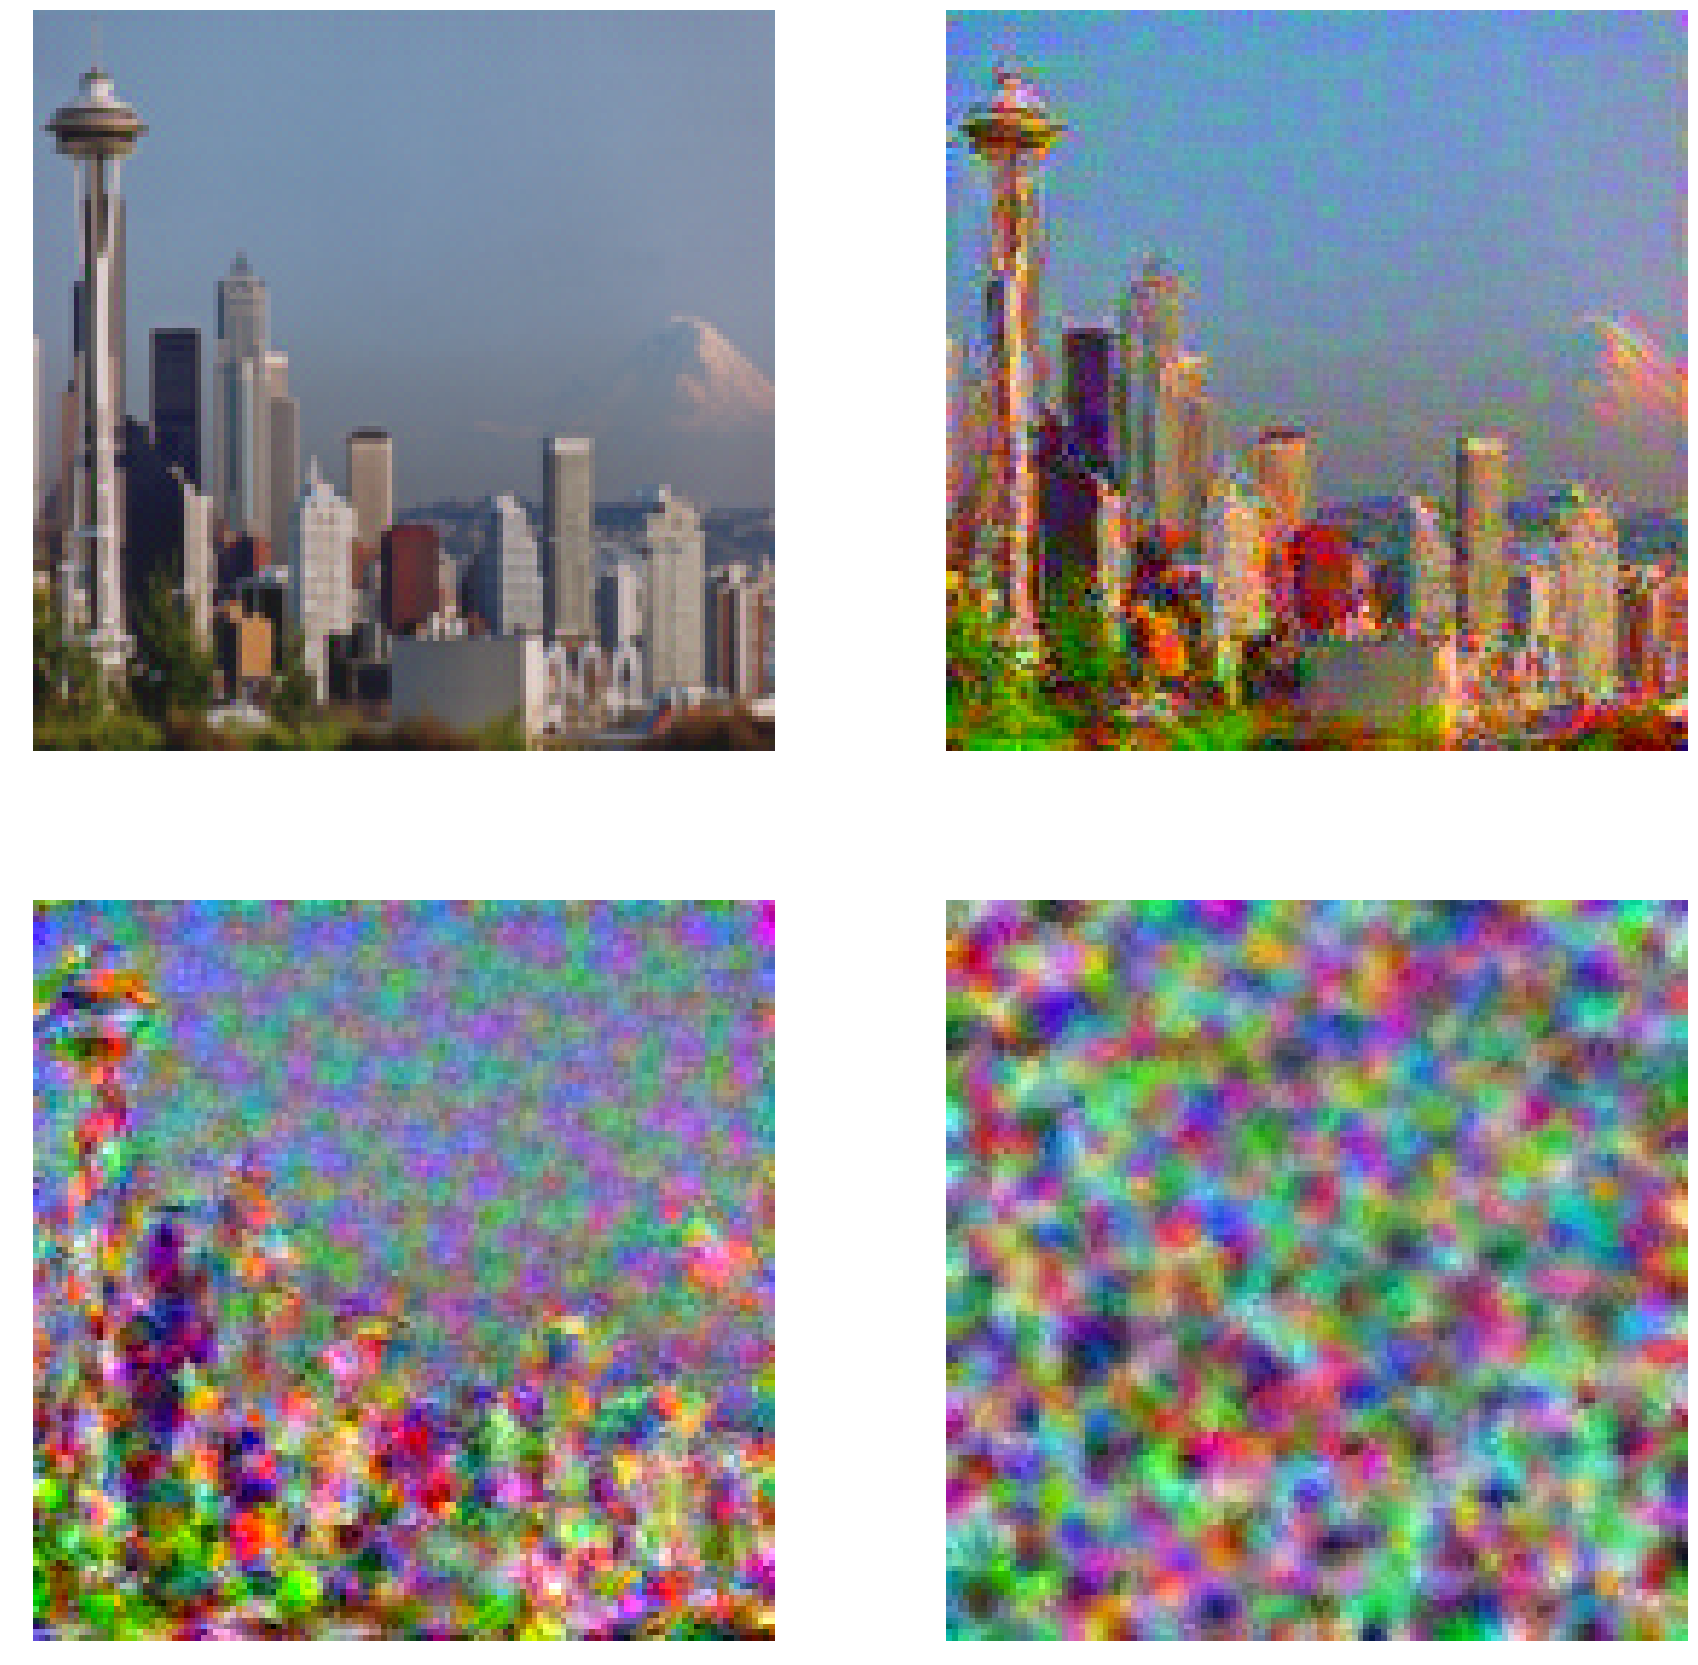

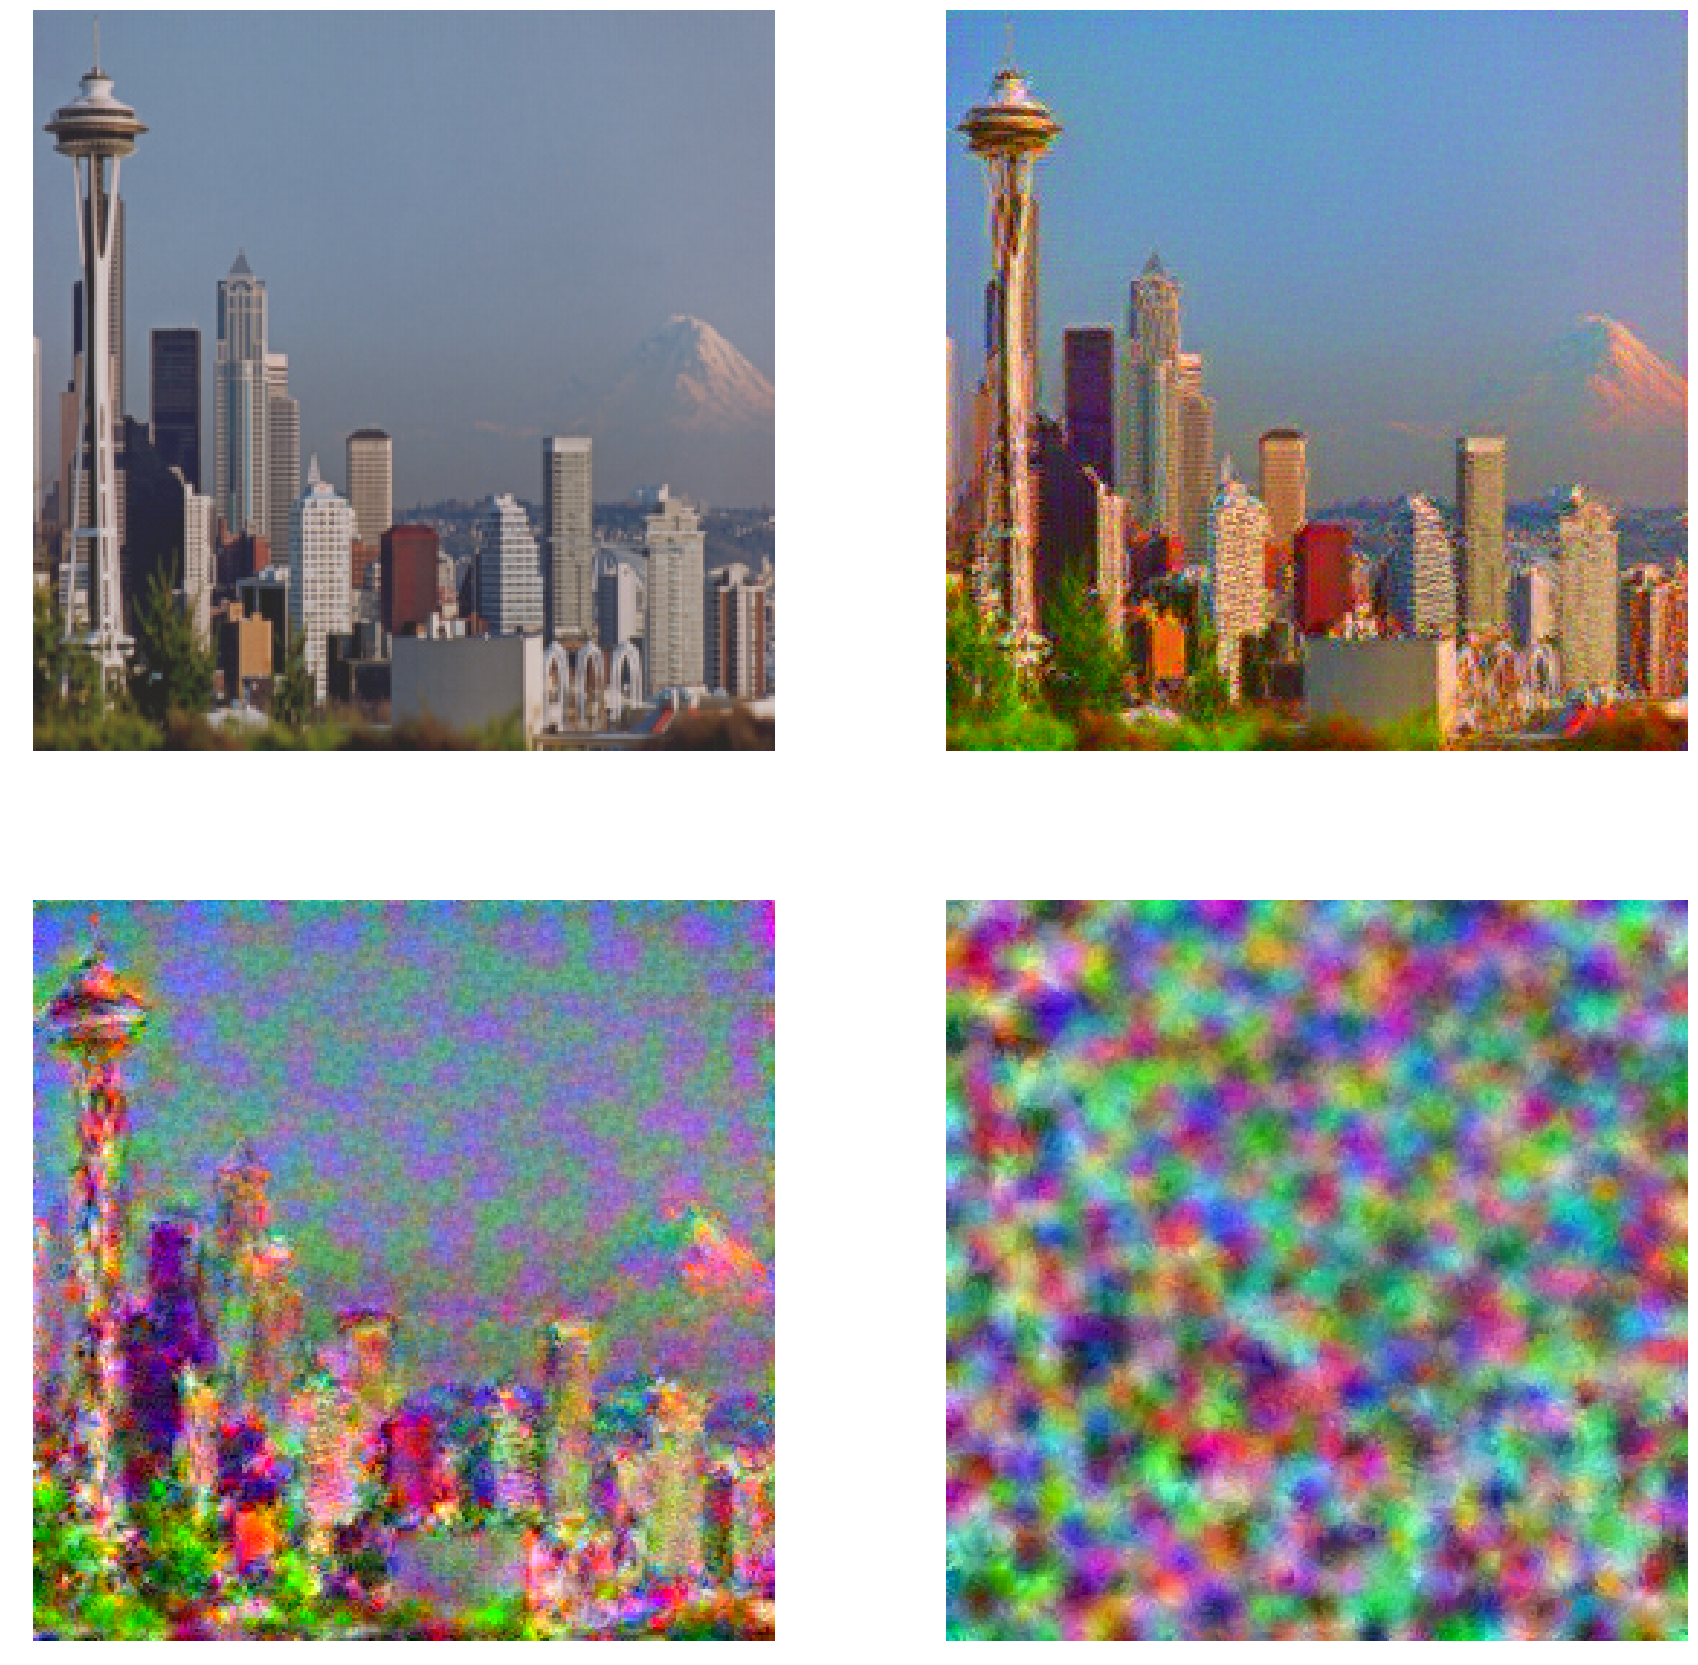

In [175]:
%%time
#layers = [8,17,26, 35]
layers = [2,4,5,6]
size = 32
imgs = [get_random_img(size) for i in range(len(layers))]
TARGET_SIZE = 256
while size <= TARGET_SIZE:
    content = load_image('images/space_needle.jpg', max_size=size)
    print('training ', size)
    trainOnLayers(imgs, content, layers, 500,lr=0.01)
    show_all(imgs)
    if size < TARGET_SIZE:
        imgs = [nn.Upsample(scale_factor=2, mode='bilinear')(img).detach_() for img in imgs]
    size *= 2

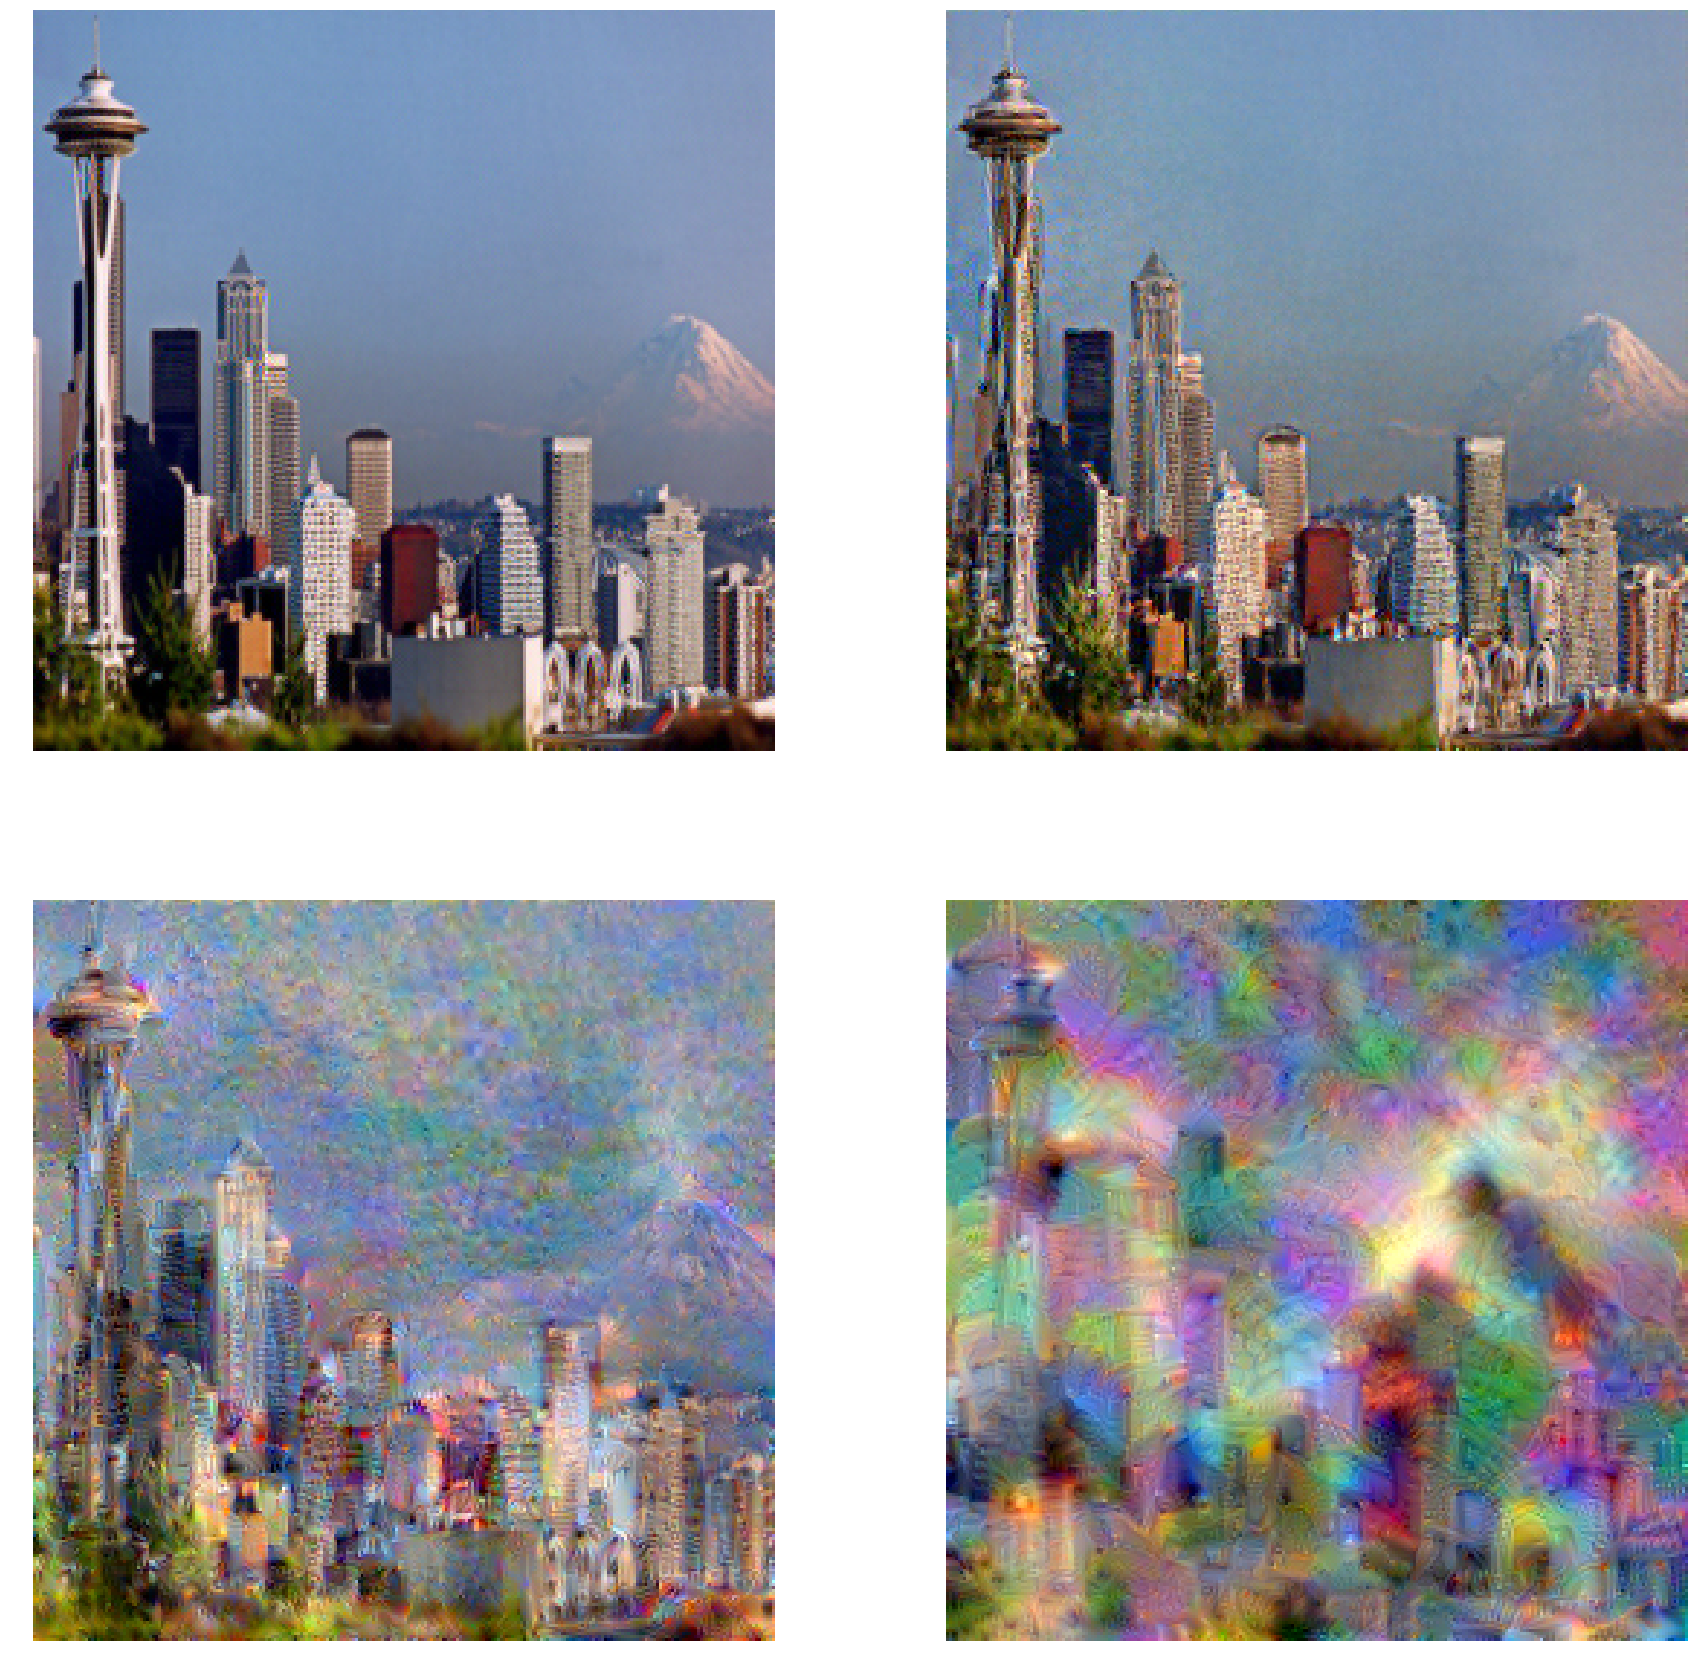

In [165]:
show_all(imgs)

In [136]:
part5 = nn.Sequential(*list(vgg.children())[:6])
part6 = nn.Sequential(*list(vgg.children())[:7])
l1=loss_fun(part5(imgs[0]), part5(content))
l2=loss_fun(part6(imgs[1]), part6(content))
(l1,l2)

(tensor(0.2862, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.0494, device='cuda:0', grad_fn=<MeanBackward1>))

training  16
tensor(0.6387, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2251, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1227, device='cuda:0', grad_fn=<MeanBackward1>)
CPU times: user 10.2 s, sys: 2.11 s, total: 12.3 s
Wall time: 12.3 s
training  32
tensor(0.7780, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3910, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2740, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1432, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1104, device='cuda:0', grad_fn=<MeanBackward1>)
CPU times: user 19.1 s, sys: 4.04 s, total: 23.1 s
Wall time: 23.2 s
training  64
tensor(1.0367, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5515, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3728, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2700, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2082, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1656, device='cu

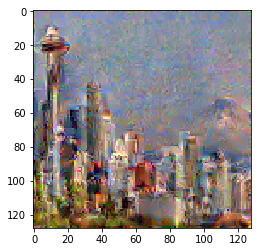

In [39]:
size = 16
input_img = get_random_img(size)
TARGET_SIZE = 128
while size <= TARGET_SIZE:
    content = load_image('images/space_needle.jpg', max_size=size)
    print('training ', size)
    %time trainAdam(input_img, content,0.1)
    plt.imshow(im_convert(input_img[0]))
    if size < TARGET_SIZE:
        input_img = nn.Upsample(scale_factor=2, mode='bilinear')(input_img)
        input_img = input_img.detach_()
    size *= 2

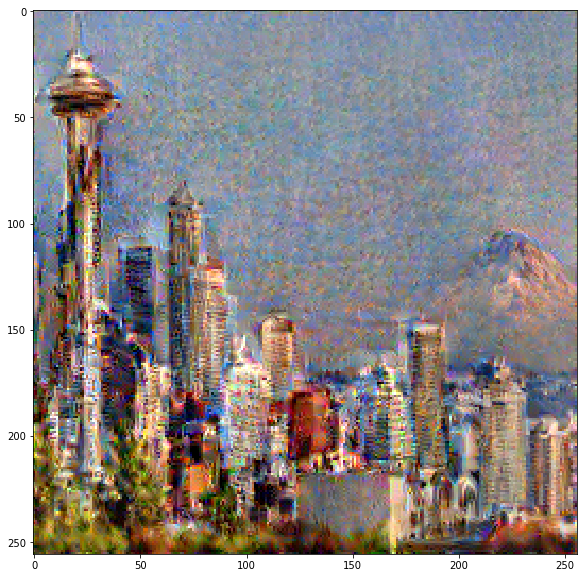

In [47]:
plt.figure(figsize = (10,10))
plt.imshow(im_convert(input_img[0]))

training  16
tensor(0.1413, device='cuda:0', grad_fn=<MeanBackward1>)
training  32
tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1523, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0978, device='cuda:0', grad_fn=<MeanBackward1>)
training  64
tensor(0.7707, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3366, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1704, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1146, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward1>)
training  128
tensor(0.6272, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3188, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2208, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1758, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1482, device='cuda:0', gra

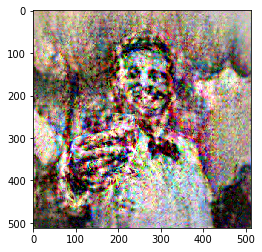

In [113]:
%%time
size = 16
input_img = get_random_img(size)
while size <= 256:
    content = load_image('images/slawek.jpg', max_size=size)
    print('training ', size)
    train(input_img, content,0.1)

    input_img = nn.Upsample(scale_factor=2, mode='bilinear')(input_img)
    input_img = input_img.detach_()
    size *= 2
plt.imshow(im_convert(input_img[0]))

In [ ]:
input_img.shape

In [ ]:
trainAdam(input_img, load_image('images/slawek.jpg', max_size=512),0.02, 0.001)

tensor(0.0478, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0351, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward1>)


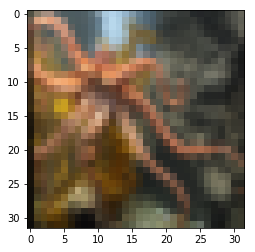

In [107]:
plt.imshow(im_convert(content[0]))